<a href="https://colab.research.google.com/github/ryancarneyy/spotify_prediction/blob/main/Spotifly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Report
---

## Dataset Description
This dataset provides a collection of data for tracks on Spotify, tracking data related to musical, lyrical, and popularity-based attributes of around 114k songs.

#### **Key Features of the Dataset**

1. **Identification and Context:**
   - **`track_id`**: Unique identifier for each track in the Spotify catalog.
   - **`artists`**: Names of the performing artist(s); multiple artists are separated by a semicolon.
   - **`album_name`**: Name of the album the track belongs to.
   - **`track_name`**: Title of the track.
   - **`track_genre`**: Genre classification of the track.

2. **Popularity and Engagement:**
   - **`popularity`**: A score (0-100) reflecting the current popularity of the track, influenced by the number and recency of plays.
   - **`explicit`**: Boolean flag indicating if the track contains explicit lyrics.

3. **Audio Characteristics:**
   - **`duration_ms`**: Length of the track in milliseconds.
   - **`danceability`**: A measure (0.0-1.0) of how suitable the track is for dancing.
   - **`energy`**: A measure (0.0-1.0) of the track’s intensity and activity.
   - **`key`**: Musical key of the track, represented numerically.
   - **`loudness`**: Overall loudness of the track in decibels.
   - **`mode`**: Musical modality of the track, with major (1) and minor (0).
   - **`tempo`**: Estimated tempo in beats per minute (BPM).
   - **`time_signature`**: The estimated time signature, ranging from 3/4 to 7/4.

4. **Lyrical and Vocal Features:**
   - **`speechiness`**: Measure (0.0-1.0) of the presence of spoken words in the track.
   - **`acousticness`**: Confidence score (0.0-1.0) indicating whether the track is acoustic.
   - **`instrumentalness`**: Likelihood (0.0-1.0) that the track contains no vocals.
   - **`liveness`**: Probability (0.0-1.0) of a live audience presence in the recording.
   - **`valence`**: Positivity measure (0.0-1.0), describing the emotional tone of the track.

## Problem Addressed
- This project aims to predict the danceability of songs based on other features from the dataset.






Introduction
---


---

Although *popularity* would be a fun response variable to choose, the flaws in the algorithm which represent "popularity" have turned us away from using it as our response variable. A major flaw is the fact that "Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past." This makes it harder to predict popularity as we don't have the data on when it was played, so if a song WAS popular, it wouldn't register as so nowadays.


---


A response variable that seems better, however, is

**danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

The reason why this seems better is because there are many characteristics from the dataset that could tell us how suitable a song is to be danced to. Predicting danceability could also be good for some sort of application in which making sure that the next songs to be played are all good/easy to dance to.



Week 2 - Data Cleaning and EDA
---
---



In [ ]:
# Our team decided to use the Spotify dataset.
# The question we will be exploring is "Can we predict a song's valence using its musical features?"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In order to use the data with full confidence, some cleaning is needed. First, we checked for and filled in missing values with corresponding means, medians, and modes.

In [ ]:
# Check for missing values.
print("Missing values before cleaning:\n", df.isnull().sum())
print("\n")

# Drop rows where critical features like track_id or track_name are missing.
df_cleaned = df.dropna(subset=['track_id', 'track_name'])

# Key is a special feature. If a key cannot be determined, the key is assigned a value of -1.
missing_key_count = (df_cleaned['key'] == -1).sum()
print("Number of songs without a key: ", missing_key_count)

# Fill in missing numerical values with their corresponding feature's mean or median.
df_cleaned.loc[:, 'popularity'] = df_cleaned['popularity'].fillna(df_cleaned['popularity'].mean())
df_cleaned.loc[:, 'danceability'] = df_cleaned['danceability'].fillna(df_cleaned['danceability'].median())
df_cleaned.loc[:, 'energy'] = df_cleaned['energy'].fillna(df_cleaned['energy'].mean())
df_cleaned.loc[:, 'loudness'] = df_cleaned['loudness'].fillna(df_cleaned['loudness'].median())
df_cleaned.loc[:, 'liveness'] = df_cleaned['liveness'].fillna(df_cleaned['liveness'].mean())
df_cleaned.loc[:, 'tempo'] = df_cleaned['tempo'].fillna(df_cleaned['tempo'].mean())

# Fill missing categorical values with their corresponding feature's most common value (mode).
df_cleaned.loc[:, 'track_genre'] = df_cleaned['track_genre'].fillna(df_cleaned['track_genre'].mode()[0])
df_cleaned.loc[:, 'explicit'] = df_cleaned['explicit'].fillna(df_cleaned['explicit'].mode()[0])

# Verify that we have no more missing values.
print("\n\nMissing values after cleaning:\n", df_cleaned.isnull().sum())

Missing values before cleaning:
 Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


Number of songs without a key:  0


Missing values after cleaning:
 Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time

Then, we checked for outliers and removed duplicate data for the same track.

In [ ]:
# Remove duplicates based on the track_id column.
df_cleaned = df_cleaned.drop_duplicates(subset=['track_id'])

# Verify that duplicates have been removed.
print("Number of duplicate track_id entries:", df_cleaned.duplicated(subset=['track_id']).sum())


Number of duplicate track_id entries: 0


We generated a description of the data across all features.

In [ ]:
df_cleaned.select_dtypes('number').describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,89740.000000,89740.000000,8.974000e+04,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000,89740.000000
mean,53479.005739,33.198808,2.291444e+05,0.562166,0.634458,5.283530,-8.498994,0.636973,0.087442,0.328285,0.173415,0.216971,0.469474,122.058134,3.897426
std,33410.141924,20.580640,1.129458e+05,0.176692,0.256606,3.559912,5.221518,0.480875,0.113278,0.338321,0.323849,0.194885,0.262864,30.117651,0.453437
min,0.000000,0.000000,8.586000e+03,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23766.750000,19.000000,1.730400e+05,0.450000,0.457000,2.000000,-10.322250,0.000000,0.036000,0.017100,0.000000,0.098200,0.249000,99.262750,4.000000
50%,50680.500000,33.000000,2.132955e+05,0.576000,0.676000,5.000000,-7.185000,1.000000,0.048900,0.188000,0.000058,0.132000,0.457000,122.013000,4.000000
75%,80618.500000,49.000000,2.642930e+05,0.692000,0.853000,8.000000,-5.108000,1.000000,0.085900,0.625000,0.097625,0.279000,0.682000,140.077000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


We generated a histogram, heat map, and bar plot to visualize the distribution of popularity, correlation between numerical features and popularity, and the average popularity across different track genres, respectively.

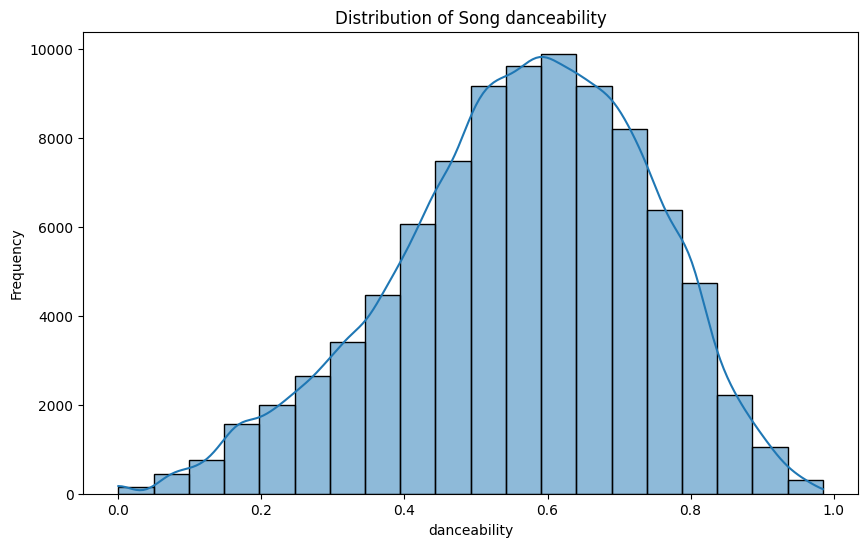

In [ ]:
# 1. Distribution of danceability
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['danceability'], bins=20, kde=True)
plt.title('Distribution of Song danceability')
plt.xlabel('danceability')
plt.ylabel('Frequency')
plt.show()

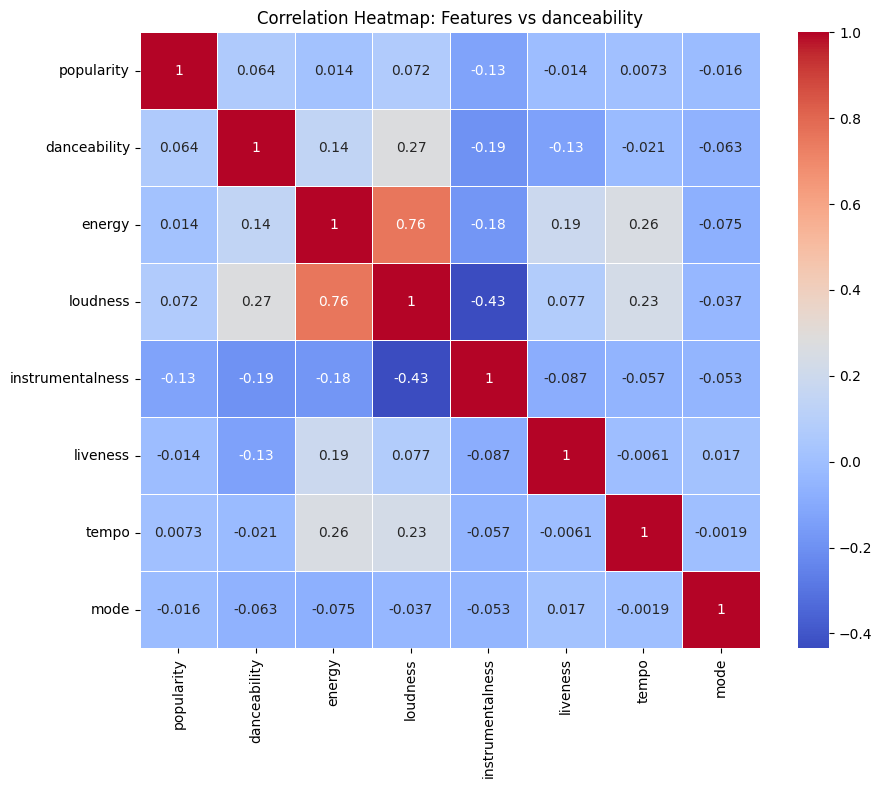

In [ ]:
# 2. Correlation Heatmap: Examine correlations between numerical features and popularity.
plt.figure(figsize=(10, 8))
correlation_matrix = df_cleaned[['popularity', 'danceability', 'energy', 'loudness', 'instrumentalness', 'liveness', 'tempo', 'mode']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Features vs danceability')
plt.show()

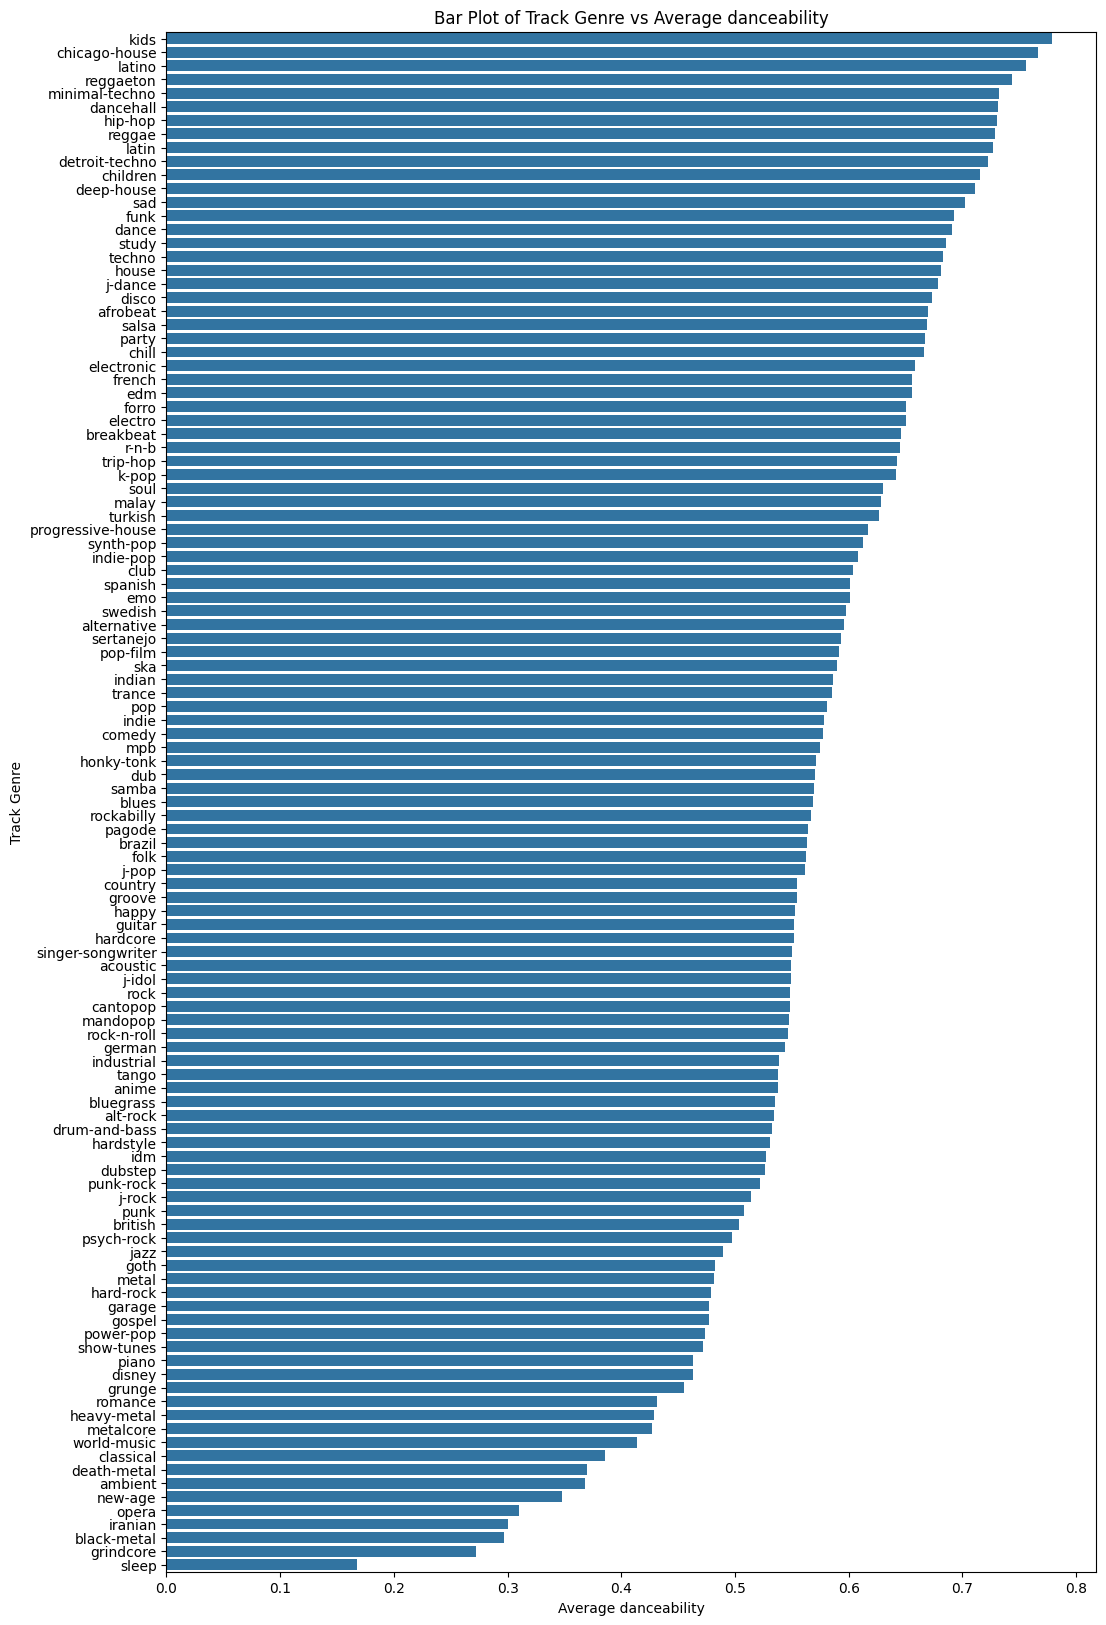

In [ ]:
# 3. Bar Plot: Compare the average danceability across different track genres.
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by track_genre and calculate their average danceability.
df_genre_danceability = df_cleaned.groupby('track_genre')['danceability'].mean().reset_index()

# Sort the genres by the average danceability in descending order.
df_genre_danceability = df_genre_danceability.sort_values(by='danceability', ascending=False)

# Set the figure size for better readability.
plt.figure(figsize=(12, 20))

# Create a bar plot to show the relationship between track_genre and average danceability.
sns.barplot(x='danceability', y='track_genre', data=df_genre_danceability)

# Add a title and labels.
plt.title('Bar Plot of Track Genre vs Average danceability')
plt.xlabel('Average danceability')
plt.ylabel('Track Genre')

# Show the plot.
plt.show()

Week 3 - Regression
---
---
**Splitting up the data**

As there was only 1 set given in the spotify dataset, we need to split it up for 70% training, 15% validation, and 15% testing.


In [ ]:
X = df_cleaned[['track_id', 'duration_ms','loudness','key','liveness','speechiness','acousticness','instrumentalness','valence', 'energy','tempo']]
y = df_cleaned['danceability']


from sklearn.model_selection import train_test_split

# Predictor variables from validation and training

# 70% train, 15% val, 15% test split

X_train, X_val, y_train, y_val= train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42, shuffle=True
)

combined_sets = pd.concat([X_train, X_val, X_test], axis=0)

combined_sets.columns
duplicates = combined_sets.duplicated(subset=['track_id']).sum()
print("Number of duplicate rows accross training, validation, and set:", duplicates)

# Get rid of track id, as we only needed it to check for data leakage
X_train = X_train.drop(columns=['track_id'])
X_val = X_val.drop(columns=['track_id'])
X_test = X_test.drop(columns=['track_id'])

# Standardizing x values
X_train_std = (X_train - X_train.mean()) / X_train.std()
X_val_std = (X_val - X_val.mean()) / X_val.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

print("Size of training set: ", X_train_std.shape)
print("Size of validation set: ", X_val_std.shape)
print("Size of testing set: ", X_test_std.shape)

Number of duplicate rows accross training, validation, and set: 0
Size of training set:  (62818, 10)
Size of validation set:  (13461, 10)
Size of testing set:  (13461, 10)


**Preparing to model our regression**


---


In order to further our knowledge on regression, we will be building a mini-model that will contain energy as the response variable.

In order to choose predictor variables for our model, we will select variables through forward selection.

In [ ]:
# Here we write forward selection algorithm from scratch
# Choosing 4 features from the 11 numerical predictor variables


# Initialize variables
selected_features = []
best_mse = float('inf')

desired_num_features = 6

# Forward selection loop
while len(selected_features) < desired_num_features:
    best_feature = None
    for feature in X_train_std.columns:
        if feature not in selected_features:
            candidate_features = selected_features + [feature]
            model = LinearRegression().fit(X_train_std[candidate_features], y_train)
            mse = mean_squared_error(y_train, model.predict(X_train_std[candidate_features]))
            if mse < best_mse:
                best_mse = mse
                best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, MSE: {best_mse}")
    else:
        break
# Setting the predictor values using the forward selection features for our linear regression
X_train_std_lr = X_train_std[selected_features]
X_val_std_lr = X_val_std[selected_features]
X_test_std_lr = X_test_std[selected_features]

print(f"Final selected features: {selected_features}")

Selected feature: valence, MSE: 0.0237852955816368
Selected feature: liveness, MSE: 0.023187042390093553
Selected feature: loudness, MSE: 0.022504334098905825
Selected feature: speechiness, MSE: 0.02203276509501839
Selected feature: energy, MSE: 0.02163770377580262
Selected feature: acousticness, MSE: 0.02090580130187217
Final selected features: ['valence', 'liveness', 'loudness', 'speechiness', 'energy', 'acousticness']


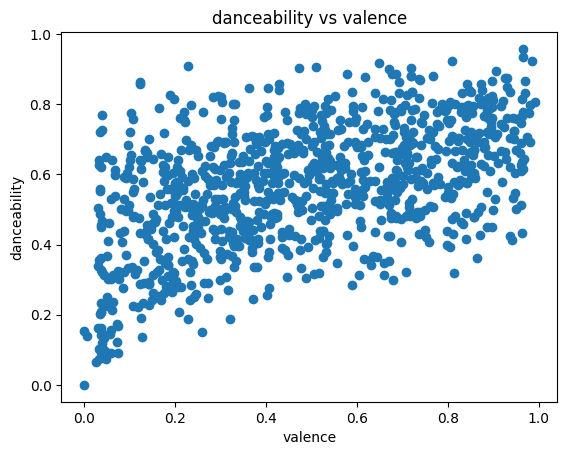

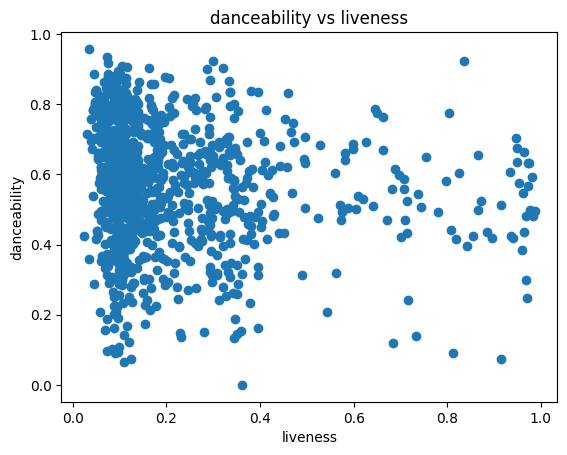

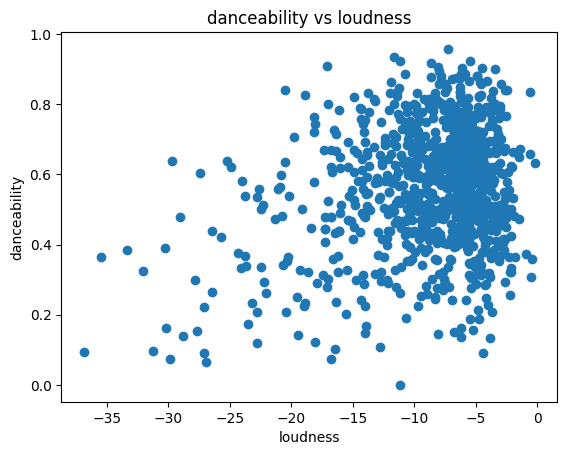

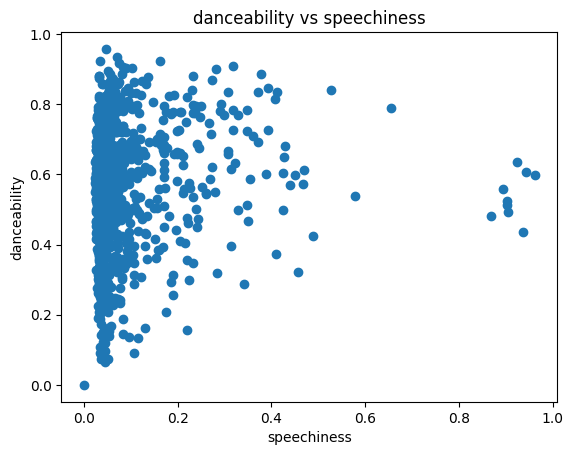

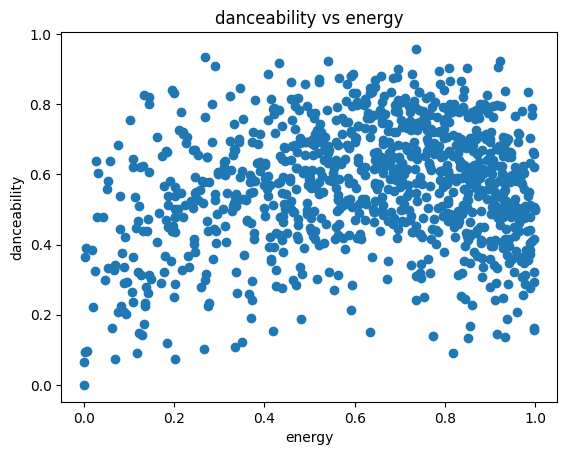

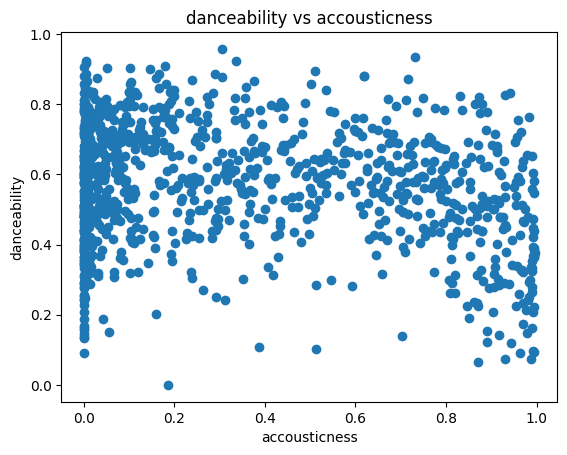

In [ ]:
# Sample data
X_sample = X.sample(1000)

valence = X_sample['valence'].values
liveness = X_sample['liveness'].values
loudness = X_sample['loudness'].values
speechiness = X_sample['speechiness'].values
energy = X_sample['energy'].values
acousticness = X_sample['acousticness'].values
danceability = y.loc[X_sample.index].values

# Creating a scatter plot of danceability vs predictors
plt.scatter(valence, danceability)
plt.title('danceability vs valence')
plt.xlabel('valence')
plt.ylabel('danceability')
plt.show()

plt.scatter(liveness, danceability)
plt.title('danceability vs liveness')
plt.xlabel('liveness')
plt.ylabel('danceability')
plt.show()

plt.scatter(loudness, danceability)
plt.title('danceability vs loudness')
plt.xlabel('loudness')
plt.ylabel('danceability')
plt.show()

plt.scatter(speechiness, danceability)
plt.title('danceability vs speechiness')
plt.xlabel('speechiness')
plt.ylabel('danceability')
plt.show()

plt.scatter(energy, danceability)
plt.title('danceability vs energy')
plt.xlabel('energy')
plt.ylabel('danceability')
plt.show()

plt.scatter(acousticness, danceability)
plt.title('danceability vs accousticness')
plt.xlabel('accousticness')
plt.ylabel('danceability')
plt.show()

Although our forward selection chose these 6 predictors as the best, we can see by sampling 1000 from each that any of the predictors' relationship with the response variable is not that clearly linear.

In [ ]:
:# Initialize the model
# danceability predictor using linear regression
dan_lin_fit = LinearRegression()

if type(X_train_std_lr) == pd.DataFrame:
  X_train_std_lr = X_train_std_lr.values
if type(X_val_std_lr) == pd.DataFrame:
  X_val_std_lr = X_val_std_lr.values
if type(X_test_std_lr) == pd.DataFrame:
  X_test_std_lr = X_test_std_lr.values

if type(y_train) == pd.DataFrame:
  y_train = y_train.values
if type(y_val) == pd.DataFrame:
  y_val = y_val.values
if type(y_test) == pd.DataFrame:
  y_test = y_test.values

# Fit the model with multiple features (X) and target variable (y)
dan_lin_fit.fit(X=X_train_std_lr,
            y=y_train)

# Display the intercept and coefficients
print("Intercept:", dan_lin_fit.intercept_)
print("Coefficients:", dan_lin_fit.coef_)

Intercept: 0.5622823362730427
Coefficients: [ 0.0841764  -0.02356247  0.04730113  0.02818241 -0.06209827 -0.04120514]


In [ ]:
from mlxtend.evaluate import bias_variance_decomp


# Evaluating the bias/variance makeup of our error

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        dan_lin_fit, X_train_std_lr, y_train, X_val_std_lr, y_val,
        loss='mse',
        random_seed=123)


print('Square root of Average expected loss (sqrt(MSE)): %.3f' % np.sqrt(avg_expected_loss))
print('Average bias: %.3f' % np.sqrt(avg_bias))
print('Average std: %.3f' % np.sqrt(avg_var))



Square root of Average expected loss (sqrt(MSE)): 0.144
Average bias: 0.144
Average std: 0.002


**Analyzing the Data**

As a result of looking at the bias and variance compared to the average expected loss, we can see that are model severely underfits the data, as most of the error is due to bias.

This is most likely due to the fact that we are using a linear model for regression, which probably doesn't fully capture the complexity of the relationship between danceability and it's predictors.




---
**Regularization of a model**


In [ ]:
from sklearn.linear_model import  Ridge, Lasso
from sklearn.model_selection import cross_val_score, cross_validate

# use 10-fold cross-validation to select the best lambda (alpha) value for the ridge regression model

# define the alpha values to test
# note that the start/stop values in the first two arguments are the exponents
alphas = np.logspace(-1, 6, 100)

# create an empty list to store the cross-validation scores
ridge_cv_scores = []

# create a for loop to compute the cross-validation score for each alpha value
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge_cv = cross_validate(estimator=ridge,
                              X=X_train_std_lr,
                              y=y_train,
                              cv=10,
                              scoring='neg_root_mean_squared_error')
    ridge_cv_scores.append({'alpha': alpha,
                            'log_alpha': np.log(alpha),
                            'test_mse': -np.mean(ridge_cv['test_score'])})

# convert the cross-validation scores into a data frame
ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

# plot the cross-validation scores as a function of alpha
px.line(ridge_cv_scores_df,
        x='log_alpha',
        y='test_mse',
        title='Ridge')

**Analyzing the MSE vs log_alpha graph**

What we see in this graph makes sense. The model that we used (linear regression) already had a very high bias and a low variance, so bringing regularization into the equation really will not help lower our error much, as its whole point is to help with high variance.


In [ ]:
# identify the value of alpha that minimizes the cross-validation score for ridge
ridge_alpha_min = ridge_cv_scores_df.sort_values(by='test_mse').head(1).alpha.values[0]
# compute the min MSE and the SE of the MSE
mse_se_ridge = ridge_cv_scores_df['test_mse'].std() / np.sqrt(10) # 10 = number of cross validation folds
mse_min_ridge = ridge_cv_scores_df['test_mse'].min()


# identify the largest value of alpha within 1 standard error, giving us decent regularization without affecting error too much.
ridge_alpha_1se = ridge_cv_scores_df[(ridge_cv_scores_df['test_mse'] <= mse_min_ridge + mse_se_ridge) &
                                     (ridge_cv_scores_df['test_mse'] >= mse_min_ridge - mse_se_ridge)].sort_values(by='alpha', ascending=False).head(1).alpha.values[0]

In [ ]:
# use ridge_alpha_min to fit the ridge regression model
ridge_min_fit = Ridge(alpha=ridge_alpha_min)
ridge_1se_fit = Ridge(alpha=ridge_alpha_1se)

# Evaluating using the alpha with the minimum MSE
avg_expected_loss_min, avg_bias_min, avg_var_min = bias_variance_decomp(
        ridge_min_fit, X_train_std_lr, y_train, X_val_std_lr, y_val,
        loss='mse',
        random_seed=123)

# Evaluating using the largest alpha within 1 standard error of min
avg_expected_loss_1se, avg_bias_1se, avg_var_1se = bias_variance_decomp(
        ridge_1se_fit, X_train_std_lr, y_train, X_val_std_lr, y_val,
        loss='mse',
        random_seed=123)

print('Using minimum MSE alpha: Bias/Variance Makeup of Error ')
print('Square root of Average expected loss (sqrt(MSE)): %.3f' % np.sqrt(avg_expected_loss_min))
print('Average bias: %.3f' % np.sqrt(avg_bias_min))
print('Average std: %.3f' % np.sqrt(avg_var_min))

print('Using largest alpha within 1 SE of min MSE: Bias/Variance Makeup of Error ')
print('Square root of Average expected loss (sqrt(MSE)): %.3f' % np.sqrt(avg_expected_loss_1se))
print('Average bias: %.3f' % np.sqrt(avg_bias_1se))
print('Average std: %.3f' % np.sqrt(avg_var_1se))



Using minimum MSE alpha: Bias/Variance Makeup of Error 
Square root of Average expected loss (sqrt(MSE)): 0.144
Average bias: 0.144
Average std: 0.002
Using largest alpha within 1 SE of min MSE: Bias/Variance Makeup of Error 
Square root of Average expected loss (sqrt(MSE)): 0.146
Average bias: 0.146
Average std: 0.001


As the model was already underfitted, the regularization techniques weren't able to do much.

This is likely because of the linear regression that we are using, as the relationships are most likely not linear.

**Week 4 - Logistic Regression**
---



---

This week we are running a logistic regression. Since logistic regression is typically used to make a binary prediction, we will have to slightly modify what we are prediction, as danceability is a continuous variable. Now, we will try to predict whether the danceability is >= 0.5. In our case, the output will be 1 if it is >= 0.5, and 0 otherwise.

We partitioned the data into a training set, validation set, and test set. We use forward selection to select numerical predictor variables for our model.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y_class = np.array([1 if danceability >= .5 else 0 for danceability in y])

if "track_id" in X.columns:
    X = X.drop(columns=['track_id'])


X_std = (X - X.mean()) / X.std()

# 70%, 15%, 15% -> train, validation, test split
X_train, X_val, y_train_class, y_val_class= train_test_split(
    X_std, y_class, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val_class, y_test_class = train_test_split(
    X_val, y_val_class, test_size=0.5, random_state=42, shuffle=True
)

# Forward selection of variables

# Initialize variables
selected_features = []
best_log_loss = float('inf')

desired_num_features = 6

# Forward selection loop
while len(selected_features) < desired_num_features:
    best_feature = None
    for feature in X_train.columns:
        if feature not in selected_features:
            candidate_features = selected_features + [feature]
            model = LogisticRegression(solver='liblinear', max_iter=500).fit(X_train[candidate_features], y_train_class)
            # Choose variables based on the log loss of the variable
            log_loss = metrics.log_loss(y_train_class, model.predict_proba(X_train[candidate_features]))
            if log_loss < best_log_loss:
                best_log_loss = log_loss
                best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, Log_loss: {best_log_loss}")
    else:
        break

print(f"Final selected features: {selected_features}")

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

lr_fwd_sel = LogisticRegression(solver='liblinear')
lr_fwd_sel.fit(X_train, y_train_class)

print('Coefficients: ', lr_fwd_sel.coef_, '\nIntercept: ', lr_fwd_sel.intercept_)
X_train

Selected feature: valence, Log_loss: 0.5493648215309003
Selected feature: liveness, Log_loss: 0.544116833916528
Selected feature: loudness, Log_loss: 0.5387108801132132
Selected feature: tempo, Log_loss: 0.5305036059621779
Selected feature: speechiness, Log_loss: 0.5266531815679849
Selected feature: acousticness, Log_loss: 0.5249401796914737
Final selected features: ['valence', 'liveness', 'loudness', 'tempo', 'speechiness', 'acousticness']
Coefficients:  [[ 1.00747933 -0.32019503  0.21625345 -0.33471608  0.22318753 -0.17230628]] 
Intercept:  [0.86408603]


,valence,liveness,loudness,tempo,speechiness,acousticness
63868,1.611199,-0.739263,0.102842,0.811878,-0.528280,-0.888462
52017,1.751957,-0.574550,0.104566,-0.867635,-0.552998,0.631694
9953,-0.656137,-0.523238,-0.164513,0.072312,0.402177,0.049406
70045,-0.359405,-0.436007,0.412906,-0.434434,-0.462954,1.500692
68998,0.496553,-0.842400,0.897248,-1.347055,0.358038,-0.550617
...,...,...,...,...,...,...
6870,-1.397967,-0.548894,0.290527,-0.317194,-0.141620,-0.524015
64791,0.131344,-0.374432,-0.359092,0.266085,-0.223719,1.675083
96881,1.287838,0.143823,0.081010,1.394095,-0.336715,0.602136
860,-1.337098,-0.661268,-1.281621,-0.592348,-0.476196,1.831739


After examining the metrics with different #s of features, we found that the accuracy and F1 score peaked at 6 features, and then started to go down. Because of this, we used these 6 features in order predict danceability with the multiple models throughout the week.

We perform logistic regression to predict the value of the mode for each song.

In [ ]:
pred_val = pd.DataFrame(dict(
    danceability_binary = y_val_class,
    lr_predict = lr_fwd_sel.predict_proba(X_val)[:,1],
    lr_predict_binary = lr_fwd_sel.predict(X_val)))
pred_val

,danceability_binary,lr_predict,lr_predict_binary
0,1,0.931157,1
1,0,0.962858,1
2,0,0.702166,1
3,0,0.537866,1
4,1,0.673579,1
...,...,...,...
13456,0,0.722651,1
13457,1,0.736223,1
13458,1,0.544079,1
13459,0,0.428523,0


We derive the confusion matrix.

In [ ]:
conf_lr = metrics.confusion_matrix(y_true=pred_val['danceability_binary'],
                                   y_pred=pred_val['lr_predict_binary'])
print("# of True Negatives:  ", conf_lr[0,0])
print("# of False Negatives: ", conf_lr[0,1])
print("# of False Positives: ", conf_lr[1,0])
print("# of True Positives:  ", conf_lr[1,1])

# of True Negatives:   2253
# of False Negatives:  2321
# of False Positives:  1233
# of True Positives:   7654


We derive the prediction accuracy, prediction error, true positive rate, and true negative rate on the training data set.



In [ ]:
# accuracy
accuracy = metrics.accuracy_score(y_true=pred_val['danceability_binary'],
                       y_pred=pred_val['lr_predict_binary'])
# error
error = 1 - accuracy

# true positive rate
true_positive = metrics.recall_score(y_true=pred_val['danceability_binary'],
                     y_pred=pred_val['lr_predict_binary'])

# true negative rate
true_negative = metrics.recall_score(y_true=pred_val['danceability_binary'],
                     y_pred=pred_val['lr_predict_binary'],
                     pos_label=0)


print('\nAccuracy:', accuracy, '\nError:', error, "\nTrue positive:", true_positive, "\nTrue negative:", true_negative)

f1 = metrics.f1_score(y_true=pred_val['danceability_binary'],
                      y_pred=pred_val['lr_predict_binary'])
print('F1 score:', f1.round(3))


Accuracy: 0.7359780105489934 
Error: 0.26402198945100663 
True positive: 0.8612580173286823 
True negative: 0.4925666812418015
F1 score: 0.812


After looking at the confusion matrix, we can see that the model actually does pretty well at predicting the correct value for danceability_binary. The accuracy is 73.5%, which is not bad, but what we really should focus on is the fact that there is a good spread of guesses. The model guess 76.7% of positives correctly, and 64% of negatives correctly.


**Visualizing our predicitons**
In order to visualize the predictions, we can graph the lr_predicted value with a coloring of the real danceability binary value to see what where exactly the model is struggling. We can see that for the most part it does really well to predict the true values correctly.

There is a large surge of true positives past the .5 mark. However, on both 1 and 0 actual values we can see that there a small amount of incorrectly predicted values. Since this proportion is somewhat even, we have confidence that our model isn't too biased in one direction.



In [ ]:
px.histogram(pred_val, x='lr_predict', color='danceability_binary',
             nbins=20, opacity=0.5,
             barmode='overlay')

We graphed the ROC Curve.

In [ ]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(y_true=pred_val['danceability_binary'],
                                                             y_score=pred_val['lr_predict'])

roc_lr = pd.DataFrame({
    'False Positive Rate': false_pos_rate,
    'True Positive Rate': true_pos_rate,
    'Model': 'Logistic Regression'
}, index=thresholds)

px.line(roc_lr, x='False Positive Rate', y='True Positive Rate',
        title='ROC Curve for Logistic Regression')

We will try using the highest difference between the true positive rate and the false positive rate as the new threshold. Since we have a lot of false positives with a threshold of 0.5 in our current model, we want to improve the spread of our model. This threshold will help make sure we are correctly predicting the most positives while also correctly predicting the most negatives.


Coincidentally, the intuition that we had is already a known way to choose the optimal threshold, which is the Youden's J Statistic, TPR - FPR.

In [ ]:
optimal_index = (true_pos_rate - false_pos_rate).argmax()
optimal_threshold = thresholds[optimal_index]

print("Optimal Threshold:", optimal_threshold)

Optimal Threshold: 0.6570631552908285


In [ ]:
pred_val = pd.DataFrame(dict(
    danceability_binary = y_val_class,
    lr_predict = lr_fwd_sel.predict_proba(X_val)[:,1],
    lr_predict_binary = lr_fwd_sel.predict(X_val)))

pred_val['lr_predict_binary_custom'] = (pred_val['lr_predict'] >= optimal_threshold).astype(int)

pred_val


,danceability_binary,lr_predict,lr_predict_binary,lr_predict_binary_custom
0,1,0.931157,1,1
1,0,0.962858,1,1
2,0,0.702166,1,1
3,0,0.537866,1,0
4,1,0.673579,1,1
...,...,...,...,...
13456,0,0.722651,1,1
13457,1,0.736223,1,1
13458,1,0.544079,1,0
13459,0,0.428523,0,0


In [ ]:
conf_lr = metrics.confusion_matrix(y_true=pred_val['danceability_binary'],
                                   y_pred=pred_val['lr_predict_binary_custom'])
conf_lr

array([[3286, 1288],
       [2656, 6231]])

In [ ]:
# accuracy
accuracy = metrics.accuracy_score(y_true=pred_val['danceability_binary'],
                       y_pred=pred_val['lr_predict_binary_custom'])
# error
error = 1 - accuracy

# true positive rate
true_positive = metrics.recall_score(y_true=pred_val['danceability_binary'],
                     y_pred=pred_val['lr_predict_binary_custom'])

# true negative rate
true_negative = metrics.recall_score(y_true=pred_val['danceability_binary'],
                     y_pred=pred_val['lr_predict_binary_custom'],
                     pos_label=0)

print('\nAccuracy:', accuracy, '\nError:', error, "\nTrue positive:", true_positive, "\nTrue negative:", true_negative)


f1 = metrics.f1_score(y_true=pred_val['danceability_binary'],
                      y_pred=pred_val['lr_predict_binary_custom'])
print('F1 score:', f1.round(3))



Accuracy: 0.7070054230740658 
Error: 0.2929945769259342 
True positive: 0.7011364915044447 
True negative: 0.7184083952776563
F1 score: 0.76


**Analyzing the Metrics with the "Optimal Threshold"**

Interestingly enough, even after using the "Optimal Threshold" from the ROC curve, we actually had better metrics in every department except for the true negative rate in our first model. Having better predictions in this one category would not justify using this model instead of our original.



**Next, we will get the area under the curve to see how well the model is predicting the probability of a randomly selected 1 mode vs a randomly selected 0 mode**

In [ ]:
# Logistic regression
lr_auc = metrics.roc_auc_score(pred_val['danceability_binary'], pred_val['lr_predict'])
print('Logistic regression AUC:', lr_auc.round(3))

Logistic regression AUC: 0.782


As the AUC is .782, it means that we have a decent model for predicting whether a song has a danceability of >= 0.5 or not. While not perfect, it is better than random guessing and indicates that the model can reliably distinguish between classes in most cases.

**Cross Validation**


In [ ]:
from sklearn.model_selection import cross_val_score
X_val, y_val_class
# Getting a auc scoring with a 5-fold cross validation
cross_val_score(lr_fwd_sel, X_val, y_val_class, cv=5, scoring='roc_auc')

array([0.79508258, 0.7964103 , 0.77431848, 0.77457064, 0.77127165])

Just like in the training data, the AUC hovers right around .78, which is an acceptable score for the metric, as the dataset is quite noisy.

**Week 5 - KNN**
---



---



**How KNN works**

KNN works by looking at the K nearest data points (by euclidean distance) to the one your are looking at. You choose the binary output to be the output of the majority of the KNN.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create the KNN regressor
knn_classifier = KNeighborsClassifier(n_neighbors=7)

# Fit the regressor to the data
knn_classifier.fit(X_train, y_train_class)  # X_train is the feature matrix, y_train is the target

# Predict the value for a new data point
dance_pred = knn_classifier.predict(X_val)  # X_test is the test feature matrix

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val_class, dance_pred)
print("Accuracy:", accuracy)



Accuracy: 0.7759453235272268


We chose a value of 7 for k, as after multiple attempts we found that it gave the best validation scores for metrics like accuracy and f1 score.

**Although the accuracy is important, we want to look at the confusion matrix to better understand where our predictor is going wrong**

In [ ]:
conf_knn = metrics.confusion_matrix(y_true=y_val_class,
                                   y_pred=dance_pred)
print("# of True Negatives:  ", conf_lr[0,0])
print("# of False Negatives: ", conf_lr[0,1])
print("# of False Positives: ", conf_lr[1,0])
print("# of True Positives:  ", conf_lr[1,1])

# of True Negatives:   3286
# of False Negatives:  1288
# of False Positives:  2656
# of True Positives:   6231


**Along with the confusion matrix, there are also other statistics we look at in order to evaluate the model**

In [ ]:
# error
error = 1 - accuracy

# true positive rate
true_positive = metrics.recall_score(y_true=y_val_class, y_pred=dance_pred)

# true negative rate
true_negative = metrics.recall_score(y_true=y_val_class, y_pred=dance_pred, pos_label=0)


print('\nAccuracy:', accuracy, '\nError:', error, "\nTrue positive:", true_positive, "\nTrue negative:", true_negative)

f1 = metrics.f1_score(y_true=y_val_class, y_pred=dance_pred)

print('F1 score:', f1.round(3))


Accuracy: 0.7759453235272268 
Error: 0.22405467647277322 
True positive: 0.8618206368853382 
True negative: 0.6090948841276782
F1 score: 0.835


### **Analyzing the metrics**

Based on the confusion matrix, we can see that this time there is a much larger spread of predictions.

**In the original log regression we used last week, the confusion matrix looked like this:**

Number of True Negatives:   2251

Number of False Negatives:  2323

Number of False Positives:  1232

Number of True Positives:   7655


**When using KNN (k=7), the confusion matrix looks like this:**

Number of True Negatives:   3285

Number of False Negatives:  1289

Number of False Positives:  2652

Number of True Positives:   6235

**F1 Score**

The F1 score increased vary slightly when going from .81 to .835, which isn't a significant enough of a change to make any conclusing. However, the 2 metrics that had a noticeable improvment were the accuracy and the true negative score. As our true positive score stayed around the same, seeing our accuracy increase by 4% and true negative increase by 10% is a very good sign of how our KNN improved our prediction.

In [ ]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(y_true=y_val_class, y_score=dance_pred)

roc_lr = pd.DataFrame({
    'False Positive Rate': false_pos_rate,
    'True Positive Rate': true_pos_rate,
    'Model': 'Logistic Regression'
}, index=thresholds)

px.line(roc_lr, x='False Positive Rate', y='True Positive Rate',
        title='ROC Curve for Logistic Regression')

****

## Week 7 - Unsupervised Learning

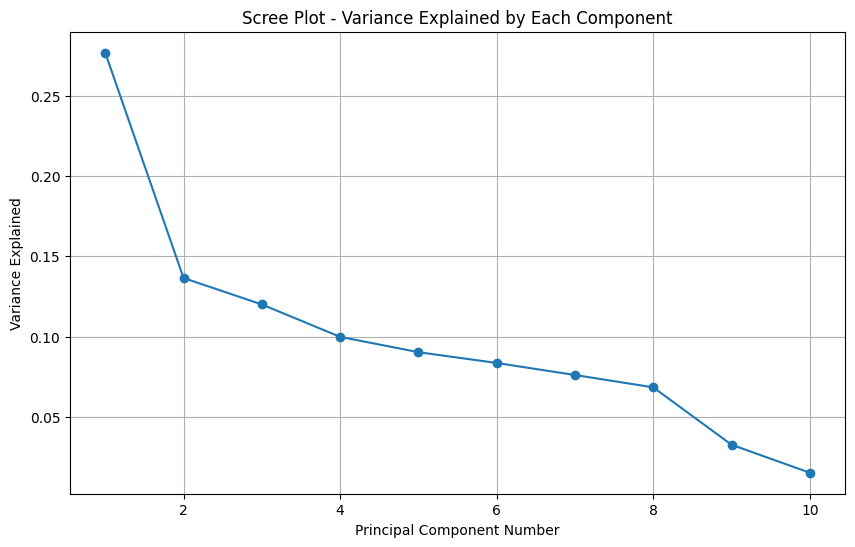

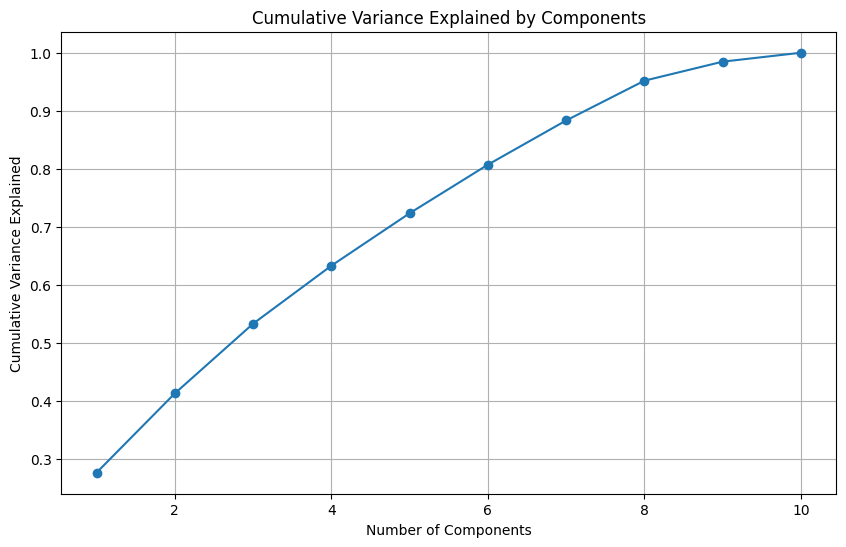

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Standardize the features. We will use the same features we have used in the 2 previous check-ins.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Proportion of variance explained by each principal component (for Scree Plot).
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explained by all principal components.
cumulative_variance = np.cumsum(explained_variance)

# Plot the Scree Plot.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.title('Scree Plot - Variance Explained by Each Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

# Plot the cumulative variance.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Variance Explained by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

Here, we are utilizing the unsupervised method, PCA, to learn the structure of the data and for dimensionality reduction. In the scree plot, the elbow can be identifed at 2 principal components. So, via the elbow method, 2 or 3 principal components is the optimal number of principal components. Choosing 2 to 3 would reduce our the dimension of our data by 3 or 4. Also, those principal components capture the most variance in the data. Further components capture less additional variance each time we raise the dimension. However, in the cumulative variability plot, we can see that to explain 95% of the variance in the data, we would still need all 6 components since 5 components explain about 92%. We may consider using clustering instead of PCA since this conclusion would not significantly help us reduce the data's dimension. Both graphs help us see the tradeoff between how many components / what dimension we need while still maximizing the amount of variance in the data we capture.

# Week 10 - Neural Networks

This week, we used Neural Networks to predict a value for danceability based on a song's features. To start, we can use the 6 selected features we have been using for the past few weeks, with those 6 features returning the best results for each of the different types of prediction techniques we used.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:

# Features from previous activities
X = df_cleaned[selected_features]

y = df_cleaned['danceability']


# 70, 15, 15 split of train, val, test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_train_tens = torch.tensor(X_train_scaled, dtype=torch.float)
# Don't need to scale y as already between 0 and 1
y_train_tens = torch.tensor(y_train.values, dtype=torch.float)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_val_tens = torch.tensor(X_val_scaled, dtype=torch.float)
y_val_tens = torch.tensor(y_val.values, dtype=torch.float)
X_test_tens = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tens = torch.tensor(y_test.values, dtype=torch.float)


print("Dimensions of X_train tensor:", X_train_tens.shape)
print("Dimensions of y_train tensor:", y_train_tens.shape)

print("Dimensions of X_val tensor:",X_val_tens.shape)
print("Dimensions of y_val tensor:",y_val_tens.shape)

print("Dimensions of X_test tensor:",X_test_tens.shape)
print("Dimensions of y_test tensor:",y_test_tens.shape)

Dimensions of X_train tensor: torch.Size([62818, 6])
Dimensions of y_train tensor: torch.Size([62818])
Dimensions of X_val tensor: torch.Size([13461, 6])
Dimensions of y_val tensor: torch.Size([13461])
Dimensions of X_test tensor: torch.Size([13461, 6])
Dimensions of y_test tensor: torch.Size([13461])


In [ ]:
class SpotifyNN(nn.Module):
    def __init__(self, num_features):
        super(SpotifyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model6 = SpotifyNN(6)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model6.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

**Training the model**

First of all, because of memory restrictions, we used mini-batches to train our dataset.

We tried a number of different sizes, first of all starting with 512, but then moving to a batch size of 128 as the model didn't seem to be converging fast enough, even with a higher learning rate of .01. After moving to 128, we saw an increase in the rate at which the model converged, which makes sense as a smaller batch size leads to the paramters being updated more frequently.


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset6 = TensorDataset(X_train_tens, y_train_tens)
train_data_loader6 = DataLoader(train_dataset6, batch_size=128, shuffle=True)


epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_data_loader6:
      # Forward pass
      predictions = model6(batch_X)
      # Loss = nn.MSELoss(predictions, y_train)
      loss = loss_fn(predictions.view(-1), batch_y)

      # Backward pass

      # resets gradients in optimizer from previous pass
      optimizer.zero_grad()
      # computers gradient of loss function
      loss.backward()
      # Updates the model parameters using the computed gradients
      optimizer.step()

      epoch_loss += loss.item()

    scheduler.step()  # Update learning rate
    epoch_loss /= len(train_data_loader6)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/100], Loss: 0.0152
Epoch [20/100], Loss: 0.0148
Epoch [30/100], Loss: 0.0142
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0137
Epoch [60/100], Loss: 0.0137
Epoch [70/100], Loss: 0.0134
Epoch [80/100], Loss: 0.0134
Epoch [90/100], Loss: 0.0132
Epoch [100/100], Loss: 0.0132


**Changing Parameters**

So far, we have been using the 6 features that were found optimal by previous algorithms, however, we can do some experimenting to find out if there is a different/smaller subset of predictors we can use in order to closer predict our response variable.

From our domain knowledge,

**Possible predictors for valence:**

- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
- **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
- **loudness:** The overall loudness of a track in decibels (dB)
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration


---
From our domain knowledge, we know that all of these could be factors in determining how high a song's "danceability" is. For example, if a songs tempo is higher, it most likely is better/easier to dance to.

In [ ]:
model_dk = SpotifyNN(6)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_dk.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [ ]:
# Features from domain knowledge
nn_features = ['valence', 'energy', 'loudness', 'tempo', 'key', 'mode']
X_dk = df_cleaned[nn_features]

# 70, 15, 15 split of train, val, test
X_train_dk, X_val_dk, y_train, y_val = train_test_split(X_dk, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train_dk_scaled = scaler.fit_transform(X_train_dk)

X_train_tens_dk = torch.tensor(X_train_dk_scaled, dtype=torch.float)
# Don't need to scale y as already between 0 and 1
y_train_tens_dk = torch.tensor(y_train.values, dtype=torch.float)

X_val_dk, X_test_dk, y_val, y_test = train_test_split(X_val_dk, y_val, test_size=0.5, random_state=42)

X_val_dk_scaled = scaler.transform(X_val_dk)
X_test_dk_scaled = scaler.transform(X_test_dk)

X_val_dk_tens = torch.tensor(X_val_dk_scaled, dtype=torch.float)
y_val_tens = torch.tensor(y_val.values, dtype=torch.float)
X_test_dk_tens = torch.tensor(X_test_dk_scaled, dtype=torch.float)
y_test_tens = torch.tensor(y_test.values, dtype=torch.float)


In [ ]:

train_dataset_dk = TensorDataset(X_train_tens_dk, y_train_tens)
train_data_loader_dk = DataLoader(train_dataset_dk, batch_size=128, shuffle=True)


epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_data_loader_dk:
      # Forward pass
      predictions = model_dk(batch_X)
      # Loss = nn.MSELoss(predictions, y_train)
      loss = loss_fn(predictions.view(-1), batch_y)

      # Backward pass

      # resets gradients in optimizer from previous pass
      optimizer.zero_grad()
      # computers gradient of loss function
      loss.backward()
      # Updates the model parameters using the computed gradients
      optimizer.step()

      epoch_loss += loss.item()

    scheduler.step()  # Update learning rate
    epoch_loss /= len(train_data_loader_dk)

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/100], Loss: 0.0171
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0164
Epoch [50/100], Loss: 0.0164
Epoch [60/100], Loss: 0.0163
Epoch [70/100], Loss: 0.0163
Epoch [80/100], Loss: 0.0163
Epoch [90/100], Loss: 0.0163
Epoch [100/100], Loss: 0.0162


**Reviewing our options**

After trying to switch parameters based on our domain knowledge, we can see that our training loss is a bit worse.

- selected_featues -> L2 Loss of .0132
- domain knowledge features -> L2 loss of .0162

However, that doesn't always mean it translates to validation or testing, so we can run evaluations using the validation set on both of our models.

**Validating our original 6-Feature model**

In [ ]:
# Evaluating metrics from our original predictors

val_dataset6 = TensorDataset(X_val_tens, y_val_tens)
val_loader6 = DataLoader(val_dataset6, batch_size=128, shuffle=True)

model6.eval()

all_predictions = []
all_targets = []

# Disable gradient computation
with torch.no_grad():
    for batch_X, batch_y in val_loader6:
        # Forward pass
        predictions = model6(batch_X).view(-1)  # Flatten predictions if necessary

        # Collect predictions and targets
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Evaluate metrics
mse = np.mean((all_predictions - all_targets) ** 2)  # Mean Squared Error
mae = mean_absolute_error(all_targets, all_predictions)  # Mean Absolute Error
r2 = r2_score(all_targets, all_predictions)  # R² Score

print(f"Validation Metrics: MSE = {mse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

Validation Metrics: MSE = 0.0142, MAE = 0.0933, R² = 0.5450


**Reviewing the metrics given from our 6-feature validation set**

The good news is that the model does NOT show signs of overfitting. Our error is very similar to the loss shown while training, so it shows that we have not overfitted to the training set and our model generally predicts the same for all observations.

As our MAE is around .93, it means we have about a 9.3% error on each prediction we make. The R2 score isn't necessarily outstanding, but based on the fact that some of the important features aren't physical features but generated by some algorithm, it is not bad. Along with the fact that a good amount of features are generated by algorithm, the reality of datasets that are more social is that they will be a lot more noisy and unpredicatable.

In [ ]:
# Evaluating metrics from our domain knowledge predictors

val_dk_dataset = TensorDataset(X_val_dk_tens, y_val_tens)
val_dk_loader = DataLoader(val_dk_dataset, batch_size=128, shuffle=True)

model_dk.eval()

all_predictions = []
all_targets = []

# Disable gradient computation
with torch.no_grad():
    for batch_X, batch_y in val_dk_loader:
        # Forward pass
        predictions = model_dk(batch_X).view(-1)  # Flatten predictions if necessary

        # Collect predictions and targets
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Evaluate metrics
mse = np.mean((all_predictions - all_targets) ** 2)  # Mean Squared Error
mae = mean_absolute_error(all_targets, all_predictions)  # Mean Absolute Error
r2 = r2_score(all_targets, all_predictions)  # R² Score

print(f"Validation Metrics: MSE = {mse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

Validation Metrics: MSE = 0.0168, MAE = 0.1029, R² = 0.4620


**Reviewing the metrics given from our 4-feature validation set**

After looking at the validation set for our domain knowledge feature model, we can see that the metrics from our original selected_features are noticeably better. The error is better by almost a whole point (1%), and the R2 score is up almost .1. Because of this, we can use the original features to run on our testing set.


In [ ]:
test6_dataset = TensorDataset(X_test_tens, y_test_tens)
test6_loader = DataLoader(test6_dataset, batch_size=128, shuffle=True)

model6.eval()

all_predictions = []
all_targets = []

# Disable gradient computation
with torch.no_grad():
    for batch_X, batch_y in test6_loader:
        # Forward pass
        predictions = model6(batch_X).view(-1)  # Flatten predictions if necessary

        # Collect predictions and targets
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(batch_y.cpu().numpy())

# Convert to NumPy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Evaluate metrics
mse = np.mean((all_predictions - all_targets) ** 2)  # Mean Squared Error
mae = mean_absolute_error(all_targets, all_predictions)  # Mean Absolute Error
r2 = r2_score(all_targets, all_predictions)  # R² Score

print(f"Testing Metrics: MSE = {mse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}")

Testing Metrics: MSE = 0.0139, MAE = 0.0925, R² = 0.5483


After looking at the metrics on our testing, we can see that the 6 features we chose are the best for neural networks. Along with this fact, with an error of only .0925 we have found the best predictor out of the methods we have chosen.

**Metrics for each of our different models**

- Linear Regression:
  - Square root of Average expected loss (sqrt(MSE)): 0.147
- Logistic Regression
  - Accuracy: 0.7359780105489934
  - Error: 0.26402198945100663
  - True positive: 0.8612580173286823
  - True negative: 0.4925666812418015
  - F1 score: 0.812
- KNN
  - Accuracy: 0.7759453235272268
  - Error: 0.22405467647277322
  - True positive: 0.8618206368853382
  - True negative: 0.6090948841276782
  - F1 score: 0.835
- Neural Networks
  - MSE = 0.0139
  - MAE = 0.0925
  - R² = 0.5483


Although we cannot directly compare all of the accuracies together, as 2 are regression models and 2 are classification models, we can see that we actually have a really good prediction with our neural network, with a small error of 9.25%, which is better than our linear regression which sits at 14.7%. The 9.25% error is impressive for this specific situationbecuase of the noisy nature of the dataset. If the dataset was in a more structured environment, we might not be able to say that this is a good error, but this is not the case.